In [1]:
# titanic에서 사용된 데이터 전처리 함수 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Null처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에서 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[0]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    # 오차행렬: [[TN, FP], [FN, TP]]
    confusion = confusion_matrix(y_test, pred)
    # 정확도: (TP + TN) / (TP + TN + FP + FN)
    accuracy = accuracy_score(y_test, pred)
    # 정밀도: TP / (FP + TP)
    precision = precision_score(y_test, pred)
    # 재현률: TP / (FN + TP)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0: .4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))
    

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('/content/drive/MyDrive/machine_learning_data/titanic/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 :  0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [4]:
import numpy as np
# pred_proba -> predict와 동일한 호출
# 개별 클래스 예측 확률 반환 (첫 번째 칼럼 0: Negative 확률, 두 번째 칼럼 1: Positive 확률)
pred_proba = lr_clf.predict_proba(X_test)
print('pred_proba array의 앞 3개만 추출 \n:', pred_proba[:3])

pred = lr_clf.predict(X_test)

# 예측 확률 array와 예측 결괏값 array를 병합하여 예측 확률과 결과값을 한눈에 확인함
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

# predcit()는 predict_proba() 메서드가 반환하는 확률 값을 가진 ndarray에서
# 정해진 임곗값 (보통 0.5)를 만족하는 ndarray의 칼럼 위치를 최종 예측 클래스로 결정
# 즉, 임곗값보다 작으면 0(Negative), 임곗값보다 크면 1(Positive) 반환

pred_proba array의 앞 3개만 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


In [5]:
# 임곗값 조절을 통해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있음
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold 값보다 같거나 작으면 0, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [6]:
# Binarizer의 threshold 설정 값을 0.4로 설정.
# 즉, 분류 결정 임곗값을 0.5 -> 0.4
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출하여 Binarizer를 적용
# (X,2) : 데이터 X개 각각에 대한 확률   -> (X,1) : 데이터 x개 각각에 대해 1인 확률
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold)
# 1일 확률이 0.4보다 작으면 0, 0.4보다 크면 1 반환
custom_predict = binarizer.fit_transform(pred_proba_1)

# 임곗값을 낮춤으로써 Positive 예측일 확률이 늘어남
# 정밀도 = TP / (FP + TP), 재현율 = TP / (FN + TP)
# Positive 예측 확률이 늘어나면서 FP, TP는 늘고 FN는 줄어들음
get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도 :  0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [7]:
# 평가 지표 조사를 위해 임곗값을 0.4 ~ 0.6으로 변환
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 실행
    for custom_threshold in thresholds:
        # 임곗값 설정
        binarizer= Binarizer(threshold=custom_threshold)

        # 1인 확률을 pred_proba[:,1].reshape(-1,1)를 통해
        # (x,1) 형태의 ndarray로 가져오고,
        # 이를 임계값에 따라 0과 1로 나눔
        custom_predict = binarizer.fit_transform(pred_proba_c1)
        print('임곗값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값:  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 :  0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값:  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 :  0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값:  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 :  0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값:  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 :  0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값:  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 :  0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [8]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

# (실제값 데이터 세트, 레이블 값이 1일 때의 예측 확률)을 precision_recall_curve 인자로 입력
# 정밀도, 재현율, 임곗값을 배열 형태로 반환함
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값의 배열의 Shape:', thresholds.shape)

# 반환된 임곗값의 배열 로우가 147건 이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index],3))
print('샘플 임계값별 임계값: ', np.round(recalls[thr_index],3))


반환된 분류 결정 임곗값의 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 임계값:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


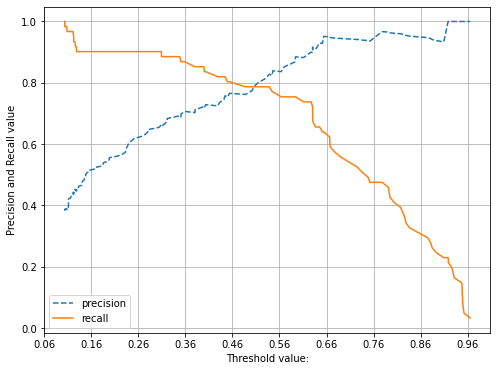

In [9]:
from pandas.errors import InvalidIndexError
# API를 이용한 정밀도와 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 실행
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    # thresholds.shape[0] = (143,) / precisions = (144,) 및 recalls.shape[0] = (144,)
    # x 축은 thresholds에 따르므로, 143개만 추출
    threshold_boundary = thresholds.shape[0]

    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],  label = 'recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value:')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1].reshape(-1,1))

In [10]:
# F1 Score: 정밀도와 재현율을 결합한 지표
# F1 = 2 * (precision * recall) / (precision + recall)
from sklearn.metrics import f1_score

# 함수에 F1 스코어 추가
def get_clf_eval(y_test, pred):
    # 오차행렬: [[TN, FP], [FN, TP]]
    confusion = confusion_matrix(y_test, pred)
    # 정확도: (TP + TN) / (TP + TN + FP + FN)
    accuracy = accuracy_score(y_test, pred)
    # 정밀도: TP / (FP + TP)
    precision = precision_score(y_test, pred)
    # 재현률: TP / (FN + TP)
    recall = recall_score(y_test, pred)
    # F1
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0: .4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)
get_eval_by_threshold(y_test, pred_proba, thresholds)

임곗값:  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 :  0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값:  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 :  0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값:  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 :  0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값:  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 :  0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값:  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 :  0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값 [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


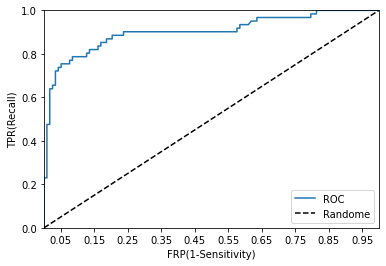

In [22]:
# ROC 곡선: 이진 분류 모델의 예측 성능 판단에 중요한 지표
# FPR(False Positive Rate)를 X축, TPR(True Positive Rate)를 Y축

# Y: TPR (민감도) = 실제값 Positive가 정확히 예측 되어야 하는 수준 = TP/(FN+TP)
#    TNR (특이성) = 실제값 Negative가 정확히 예측 되어야 하는 수준 = TN/(FP+TN)
# X: FPR = FP/(FP+TN) = (1-TNR)

from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# FPR, TPR, 임곗값 목록 반환
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 step으로 추출
# threshold[0]은 max(예측확률)+1로 임의 설정됨.
# 따라서 해당 값을 제외하기 위해 np.arange 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

def roc_curve_plot(y_test, pred_proba_c1):
    # 임곘값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label = 'ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label = 'Randome')

    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FRP(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [23]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024
